In [3]:
import pymc_marketing
pymc_marketing.__version__

'0.10.0'

In [70]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= 'whitegrid', palette='pastel')

import arviz as az

import pymc as pm

from pymc_marketing.mmm import (
    GeometricAdstock,
    LogisticSaturation,
    MMM
)
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler


In [16]:
df = pd.read_csv("data/Day5_Marketing_Mix_Modeling/mmm_dataset.csv")

In [20]:
df.head()

,date_week,revenue,tv_spend,ooh_spend,print_spend,search_spend,events,newsletter,facebook_spend
0,2015-11-23,2754371.667,167687.6,0,95463.66667,0.00000,0,19401.65385,72903.852710
1,2015-11-30,2584276.667,214600.9,0,0.00000,29511.71546,0,14791.00000,16581.099550
2,2015-12-07,2547386.667,0.0,248022,3404.00000,36132.35896,0,14544.00000,49954.773670
3,2015-12-14,2875220.000,625877.3,0,132600.00000,36804.21096,0,2800.00000,31649.297030
4,2015-12-21,2215953.333,0.0,520005,0.00000,28401.74407,0,15478.00000,8802.269479


In [17]:
df.isna().sum()

date_week         0
revenue           0
tv_spend          0
ooh_spend         0
print_spend       0
search_spend      0
events            0
newsletter        0
facebook_spend    0
dtype: int64

In [21]:
df.describe()

,revenue,tv_spend,ooh_spend,print_spend,search_spend,events,newsletter,facebook_spend
count,2.080000e+02,2.080000e+02,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,1.822143e+06,1.113277e+05,81033.639423,27964.741987,50835.620540,0.014423,22386.523669,24460.244994
std,7.162286e+05,2.141877e+05,157483.924979,48623.026739,40842.281019,0.154744,19104.164424,35097.382348
min,6.722500e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000,301.000000,0.000000
25%,1.165211e+06,0.000000e+00,0.000000,0.000000,18842.053510,0.000000,9010.500000,0.000000
50%,1.874514e+06,0.000000e+00,0.000000,0.000000,42795.757485,0.000000,19401.653850,0.000000
75%,2.378407e+06,1.380503e+05,95359.000000,35758.750002,75710.530683,0.000000,27546.500000,41212.258200
max,3.827520e+06,1.185349e+06,938178.000000,239417.333300,156564.384600,2.000000,96236.000000,178298.272900


In [22]:
output = 'revenue'
date = 'date_week'

context = ['newsletter', 'events']
media = [i for i in df.columns if 'spend' in i]
media

['tv_spend', 'ooh_spend', 'print_spend', 'search_spend', 'facebook_spend']

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

def extract_all_seasonality(df, seasonalities, window_size =4):
    if 'ds' not in df.columns or 'y' not in df.columns:
        raise ValueError("DF must contain df or y columns")
    
    df_ = df.copy()
    df_.set_index('ds', inplace = True)

    data = {}
    for name, settings in seasonalities.items():
        decomp = seasonal_decompose(
                    df_['y'],
                    model = 'additive',
                    period = settings['period']
                    )
        smoothed_seasonal = decomp.seasonal.rolling(window = window_size, center= True, min_periods =1).mean()
        data[name] = smoothed_seasonal

    result_df = pd.DataFrame(data)
    columns = list(seasonalities.keys())

    result_df[columns] = MinMaxScaler().fit_transform(result_df[columns]) 

    return result_df
    


In [42]:
df

,date_week,revenue,tv_spend,ooh_spend,print_spend,search_spend,events,newsletter,facebook_spend
0,2015-11-23,2754371.667,167687.6,0,95463.66667,0.00000,0,19401.65385,72903.852710
1,2015-11-30,2584276.667,214600.9,0,0.00000,29511.71546,0,14791.00000,16581.099550
2,2015-12-07,2547386.667,0.0,248022,3404.00000,36132.35896,0,14544.00000,49954.773670
3,2015-12-14,2875220.000,625877.3,0,132600.00000,36804.21096,0,2800.00000,31649.297030
4,2015-12-21,2215953.333,0.0,520005,0.00000,28401.74407,0,15478.00000,8802.269479
...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.000,0.0,60433,153723.66670,152840.32340,0,28157.00000,0.000000
204,2019-10-21,2182825.000,154917.6,0,0.00000,103680.04780,0,10644.00000,56881.962240
205,2019-10-28,2377706.667,21982.5,14094,17476.00000,138387.70410,0,9597.00000,0.000000
206,2019-11-04,2732825.000,22453.0,0,24051.33333,151707.99050,0,90189.00000,0.000000


In [43]:
seasonality_features = [output, date]
print(seasonality_features)

seasonal_df = df[seasonality_features].copy()
seasonal_df['ds'] = seasonal_df[date]

seasonal_df.rename(columns = {'revenue': 'y'}, inplace=True)
season_config = {
    "quarterly": {"period":12},
    "yearly":{"period":52}
}

extracted_seasons = extract_all_seasonality(seasonal_df, seasonalities=season_config)
extracted_seasons

['revenue', 'date_week']


,quarterly,yearly
ds,,
2015-11-23,1.000000,0.992432
2015-11-30,0.848212,0.935715
2015-12-07,0.752804,0.883258
2015-12-14,0.657500,0.812581
2015-12-21,0.160300,0.898525
...,...,...
2019-10-14,0.184511,0.799901
2019-10-21,0.603210,0.852038
2019-10-28,0.250610,0.903589


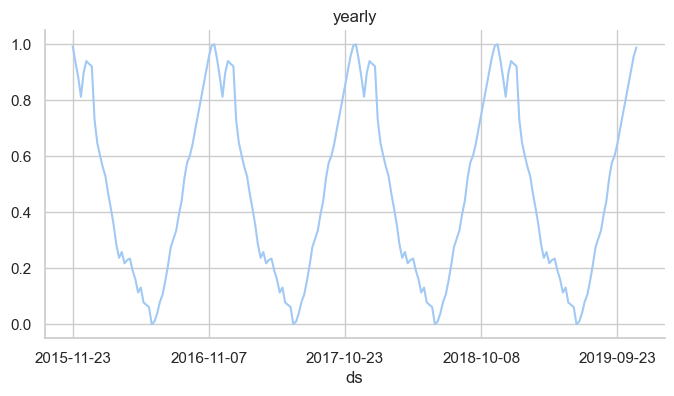

In [48]:
import matplotlib.pyplot as plt

extracted_seasons['yearly'].plot(kind='line', figsize=(8,4), title = 'yearly')
plt.gca().spines[['top', 'right']].set_visible(False)

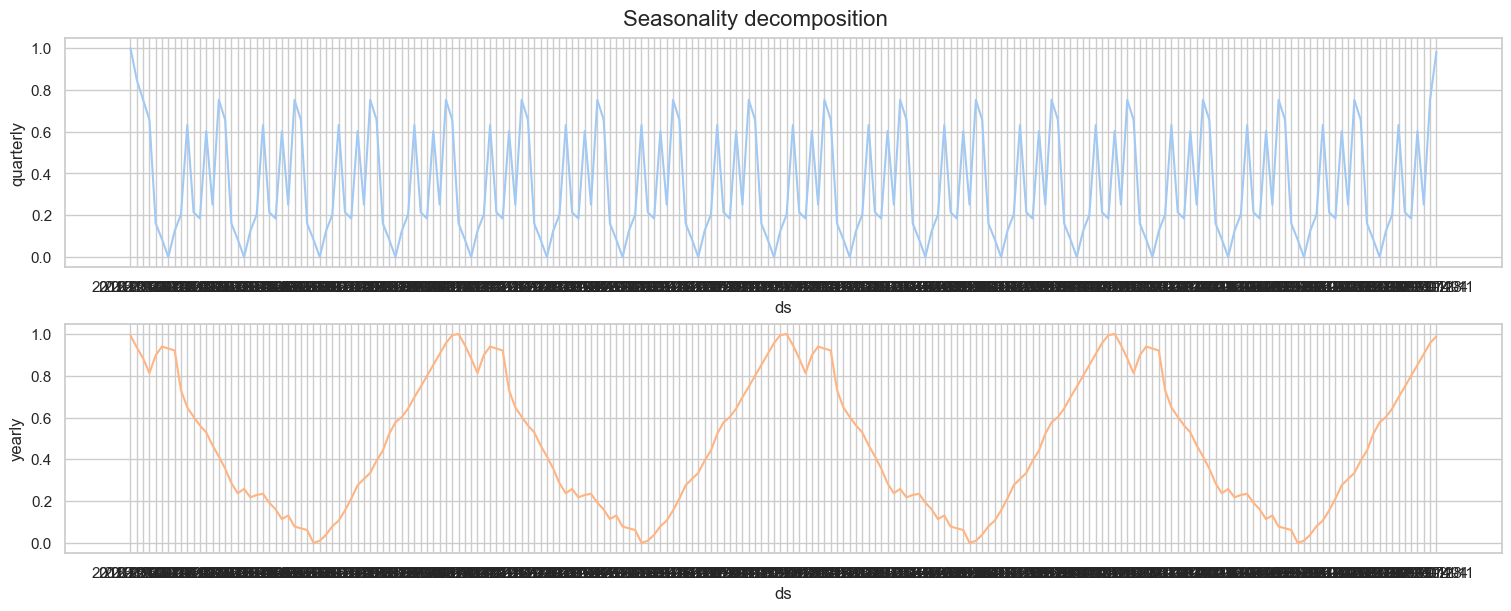

In [49]:
fig, ax = plt.subplots(
    nrows=len(season_config), ncols=1, figsize=(15, 6), layout="constrained"
)
for i, season in enumerate(season_config.keys()):
    sns.lineplot(x="ds", y=season, data=extracted_seasons, ax=ax[i], color=f"C{i}")

fig.suptitle("Seasonality decomposition", fontsize=16)
plt.show()

In [59]:
extracted_seasons = extracted_seasons.reset_index()

In [62]:
df['quarterly']=extracted_seasons['quarterly']
df['yearly']=extracted_seasons['yearly']


In [65]:
df.isna().sum()

date_week         0
revenue           0
tv_spend          0
ooh_spend         0
print_spend       0
search_spend      0
events            0
newsletter        0
facebook_spend    0
quarterly         0
yearly            0
dtype: int64

In [117]:
weeks_to_split = 4
df_train = df[:-weeks_to_split].copy()
df_test = df[-weeks_to_split:].copy()


test_dates = df_test[date].unique()
train_dates = df_train[date].unique()

In [118]:

context_var =context+['quarterly', 'yearly']


mmm = MMM(
    date_column=date,
    channel_columns=media,
    control_columns=context_var,
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    yearly_seasonality=2,
)



In [119]:
x = df_train[['date_week']+ media + context_var] 
y = df_train[output]


In [120]:
mmm.fit(x, y , target_accept = 0.95, chains =4, draws= 1000, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 67 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

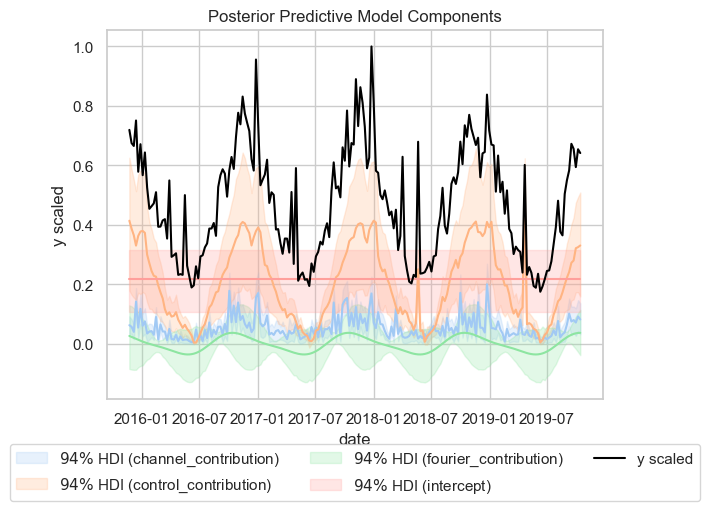

In [121]:
components_fig = mmm.plot_components_contributions()

In [126]:
get_mean_contribution_over_time=mmm.compute_mean_contributions_over_time(original_scale=True)
get_mean_contribution_over_time.head()

,tv_spend,ooh_spend,print_spend,search_spend,facebook_spend,newsletter,events,quarterly,yearly,yearly_seasonality,intercept
date,,,,,,,,,,,
2015-11-23,109046.653154,0.000000,75443.891934,0.000000,57338.791840,35938.190993,0.0,54907.714718,1.495157e+06,103225.690675,833422.458038
2015-11-30,149663.575909,0.000000,12901.081340,28503.531092,30076.096792,27397.756247,0.0,46573.373454,1.409709e+06,91038.470162,833422.458038
2015-12-07,18557.627726,40544.120341,6719.141628,39594.655315,50512.565886,26940.231686,0.0,41334.755920,1.330680e+06,78460.829002,833422.458038
2015-12-14,344159.349656,15564.549074,101033.402247,42728.440918,41957.849990,5186.513251,0.0,36101.808229,1.224201e+06,65873.564913,833422.458038
2015-12-21,47956.290263,86217.548164,18716.744689,36023.094324,22011.880874,28670.304320,0.0,8801.699668,1.353680e+06,53592.580274,833422.458038


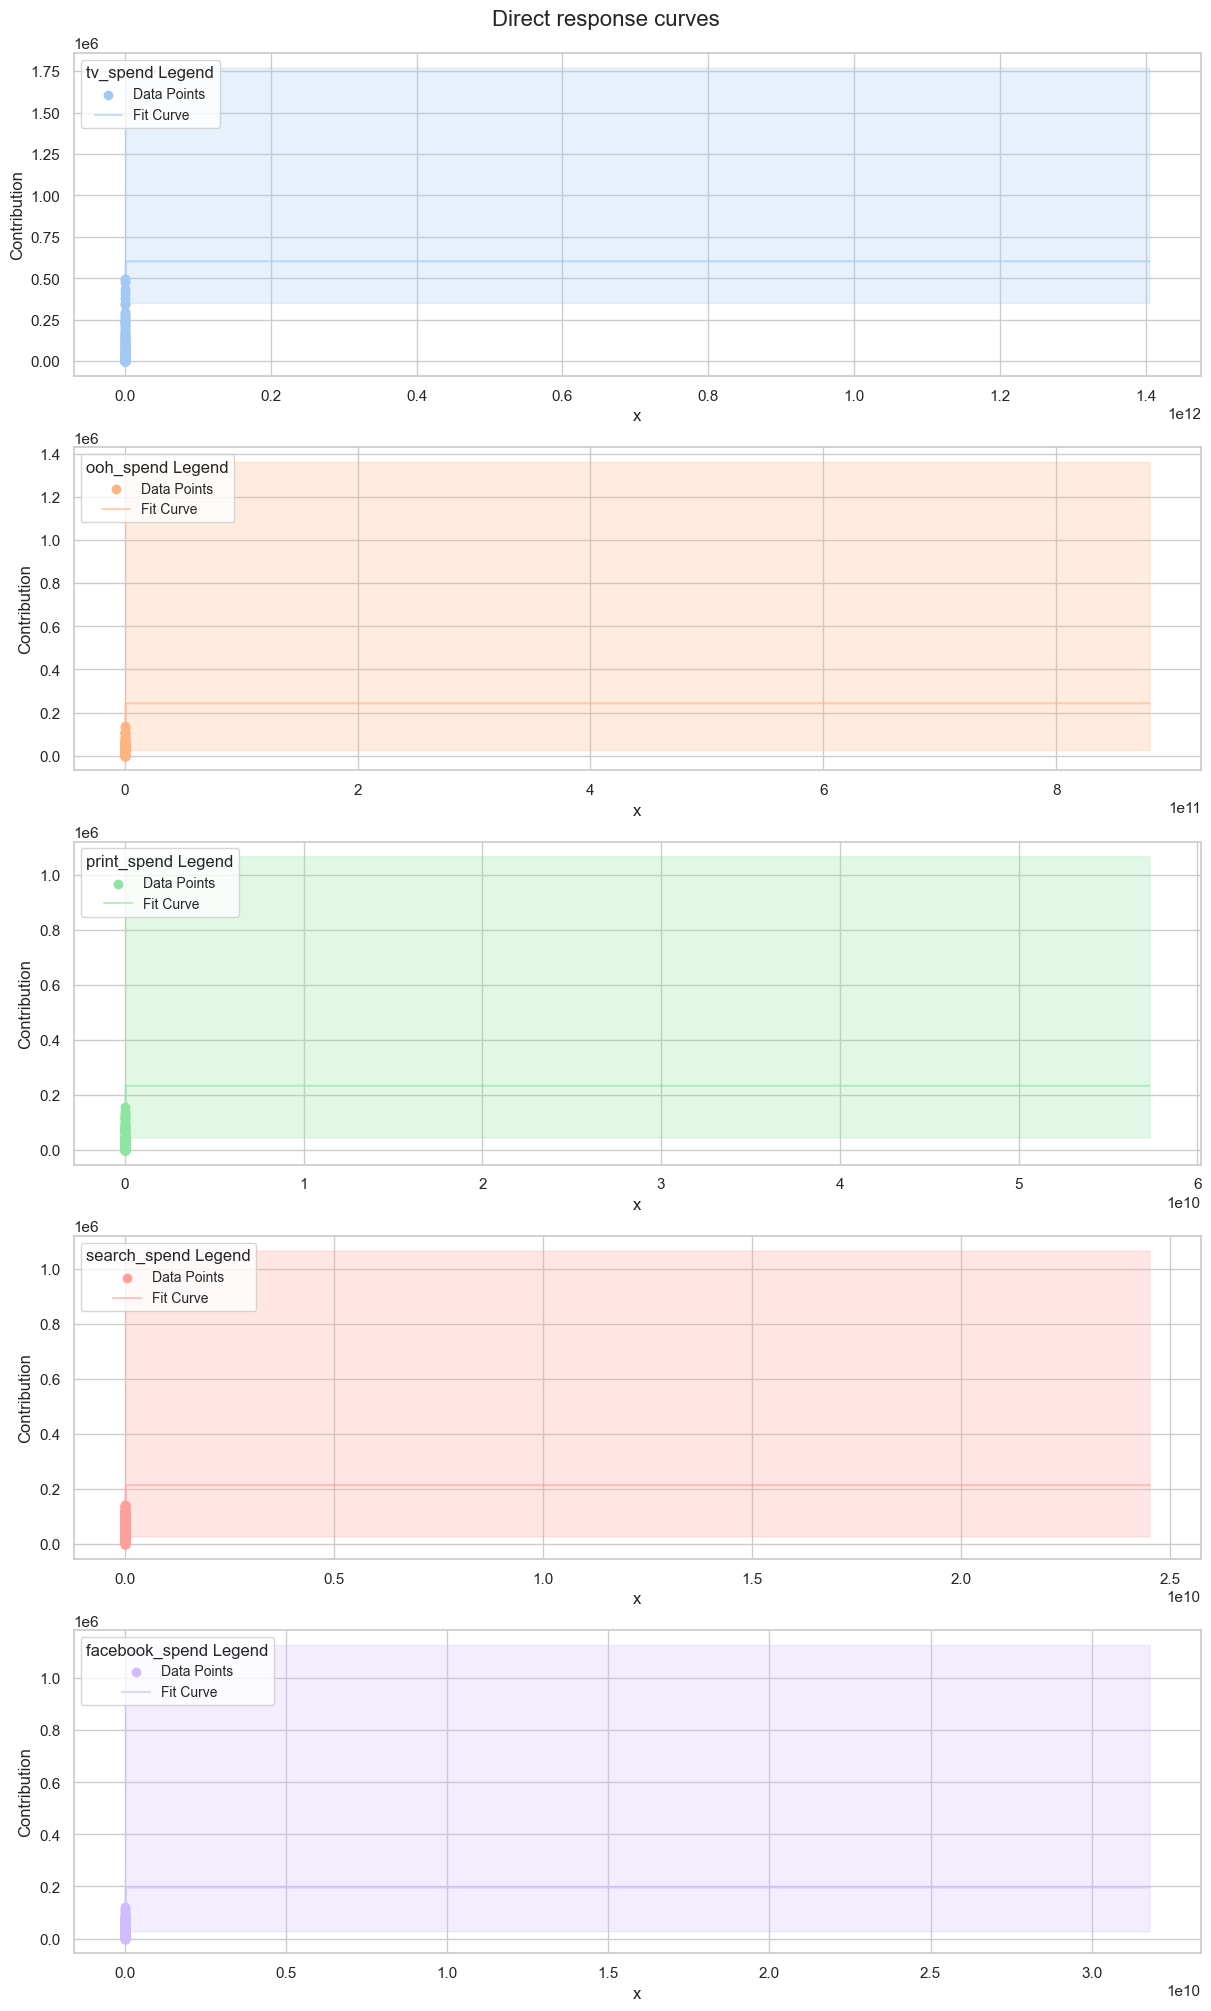

In [142]:
fig = mmm.plot_direct_contribution_curves(show_fit=True)
[ax.set(xlabel='x') for ax in fig.axes];

In [130]:
x['date_week'] = pd.to_datetime(x['date_week'])

In [131]:
mmm.predict_posterior(X_pred=x)

Sampling: [y]


<xarray.DataArray 'y' (date: 204, sample: 4000)> Size: 7MB
array([[2961993.07580573, 2911553.18788026, 2838074.80093438, ...,
        2926414.71360036, 2750338.19876151, 3040337.44698376],
       [2844852.51956831, 2397738.91851116, 2191954.56529857, ...,
        2873706.80669467, 2603724.22788869, 2577394.74848624],
       [2608153.94185159, 2601148.86058542, 1791289.03622119, ...,
        2556989.54086888, 2687372.10302839, 2240954.43832312],
       ...,
       [2154471.33701408, 2305763.28135523, 1846394.53409103, ...,
        2680902.95450918, 2026261.69979711, 2601895.90975742],
       [2397713.12191228, 2647368.61261052, 2394635.65255713, ...,
        2276963.82192667, 2220196.62252573, 2455848.15286678],
       [1999914.61826362, 2841098.02483466, 2765009.17408434, ...,
        2467084.2825231 , 2446365.86716982, 3040842.84774571]])
Coordinates:
  * date     (date) datetime64[ns] 2kB 2015-11-23 2015-11-30 ... 2019-10-14
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

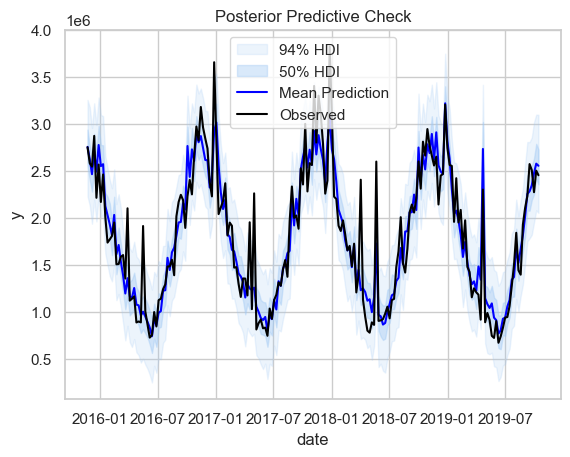

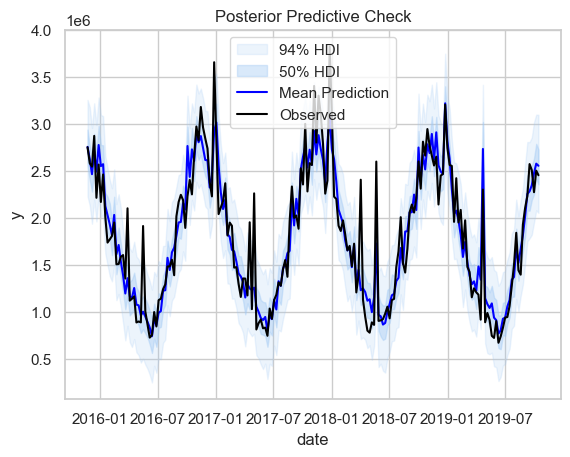

In [132]:
mmm.plot_posterior_predictive(original_scale=True)

In [134]:
from sklearn.metrics import r2_score, mean_absolute_error
y_true = y
y_pred=mmm.predict(x)

r2 = r2_score(y_true, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('r^2', r2)
print('mape', mape)

Sampling: [y]


r^2 0.8731348939140348
mape 10.248644134797493


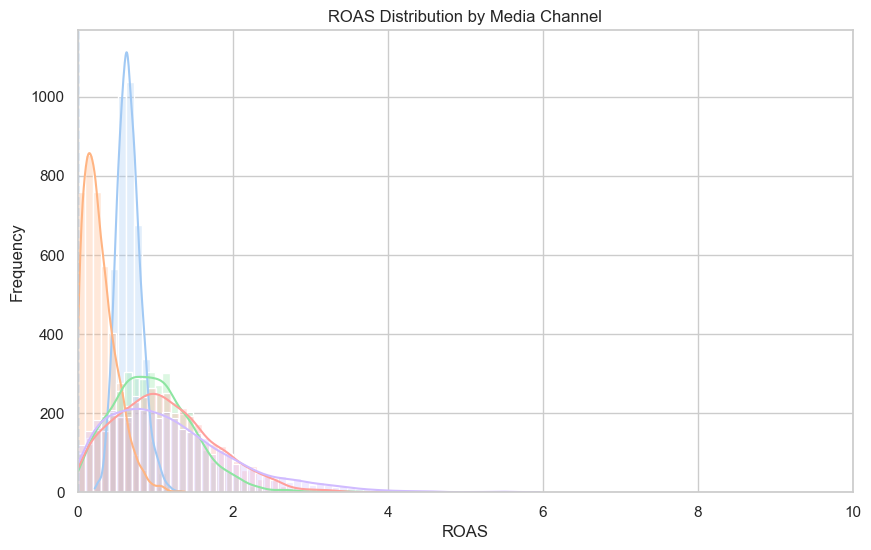

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / df_train[media].sum().to_numpy()[..., None]
)
fig, ax = plt.subplots(figsize=(10, 6))

x_min, x_max = 0, 10  
bin_width = 0.1  

for i in media:
    sns.histplot(
        roas_samples.sel(channel=i).to_numpy(), binwidth=bin_width, alpha=0.3, kde=True, ax=ax
    )
    ax.axvline(color="C0", linestyle="--", label=f'true ROAS {i}')

ax.set_xlim(x_min, x_max)  # Set the limits for the x-axis
plt.title('ROAS Distribution by Media Channel')
plt.xlabel('ROAS')
plt.ylabel('Frequency')

plt.show()


In [137]:

X_test = df_test[['date_week']+ media + context_var]   
y_test = df_test[output]

X_test['date_week'] =  pd.to_datetime(X_test['date_week'])

print("Shape of X_test:", X_test.shape)

y_pred = mmm.predict(X_test)
y_true = y_test.copy()
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('r^2', r2)
print('mape', mape)

Sampling: [y]


Shape of X_test: (4, 10)


r^2 0.2847927922295024
mape 7.3307569498801906


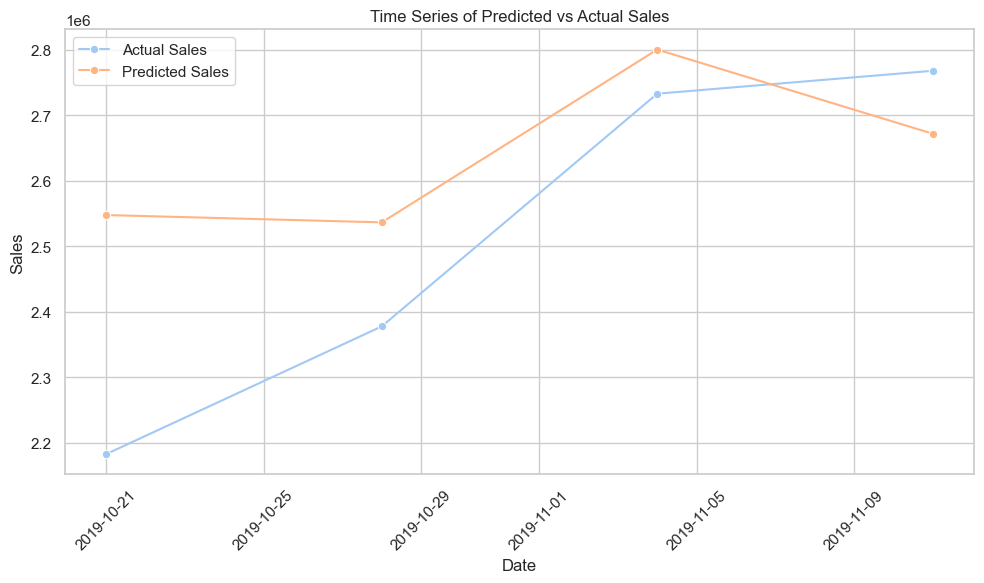

In [138]:
data = {
    'Date': df_test['date_week'],        
    'Actual Sales': y_test,
    'Predicted Sales': y_pred
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])  
df.sort_values('Date', inplace=True)    
# Set the size of the plot
plt.figure(figsize=(10, 6))

sns.lineplot(x='Date', y='Actual Sales', data=df, label='Actual Sales', marker='o')
sns.lineplot(x='Date', y='Predicted Sales', data=df, label='Predicted Sales', marker='o')

# Adding titles and labels
plt.title('Time Series of Predicted vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')


plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()      
plt.show()


In [141]:
media

['tv_spend', 'ooh_spend', 'print_spend', 'search_spend', 'facebook_spend']

In [146]:
total_budget = 208000 
channels = media
budget_per_channel = total_budget / len(channels)
initial_budget_dict = {channel: budget_per_channel for channel in channels} ## Assuming intial budget is equally distributed among channels

min_budget, max_budget = 1, 208000
budget_bounds = {channel: [min_budget, max_budget] for channel in channels}

In [147]:
response = mmm.allocate_budget_to_maximize_response(
    budget=total_budget,
    num_periods=8,
    time_granularity="weekly",
    budget_bounds=budget_bounds,
)

Sampling: [y]


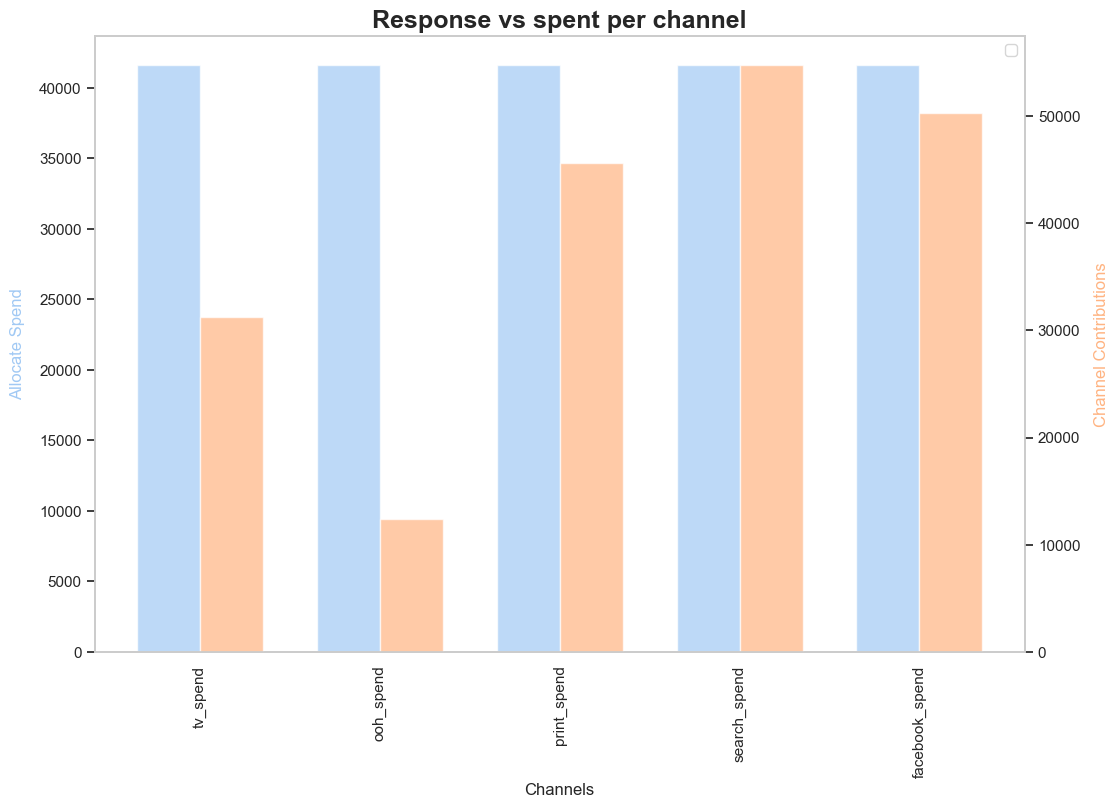

In [149]:
fig, ax = mmm.plot_budget_allocation(samples=response, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

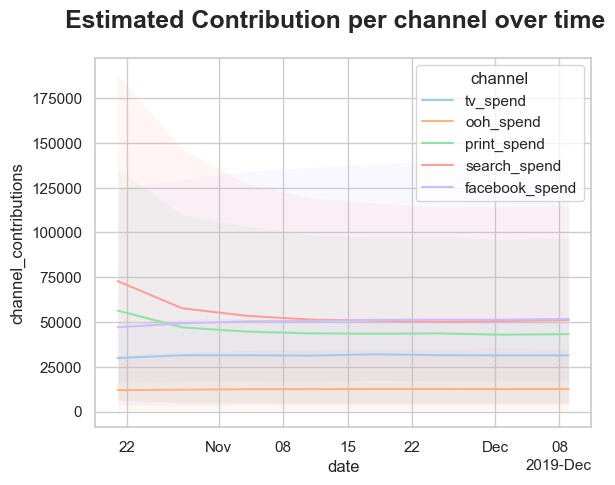

In [150]:
fig = mmm.plot_allocated_contribution_by_channel(samples=response)
fig.suptitle(
    "Estimated Contribution per channel over time", fontsize=18, fontweight="bold"
);